## Predicting Financial Fraud of Firms
## 1.0 Introduction

Firms report financial statements for every quarter and annual period. These statements are first reported internally by the organization, which in turn must be audited by accredited auditing firms to verify that the reports are accurate. Firms may be incentivized to create fraud within their reports for financial benefits such as taxation and value inflation. Fraudulent activity can cause massive monetary loss for investors (Hajek 2017), government organizations (Lin 2015), and individuals (Lin 2015). Fraudulent activity is also increasing (Lin 2015). Market participants have lost over $500 billion in recent years due to fraud (Rezaee 2002). This marks growing importance for developing better ways of detecting and eliminating financial fraud.

The question we want to answer is: <strong>How accurately can we predict if a firm is fraudulent based on its reported vs audited monetary spending discrepancies, amount of money involved in misstatements, and historical monetary loss?</strong> (How we chose these variables is in <strong>1.13</strong>)

The dataset that will be used to answer this question is Audit Data. Audit Data contains risk factor classifications and methods used by the external auditing firm. It contains reports from 777 firms from 46 different listings and 14 different sector scores. (Hooda 2018) Each observation has 27 values associated with it. However, many of these variables were not described in relevant articles. Additionally, some of the variables are calculated values determined with external analysis. These two types of variables are omitted in this analysis. 

### Variable used in analysis:

<ol>
    <li>PARA_A : Discrepancy in planned spending (Rs crore) (Hooda 2018)</li>
    <li>PARA_B : Discrepancy in unplanned spending (Rs crore) (Hooda 2018)</li>
    <li><strong>TOTAL</strong> : Sum of PARA_A and PARA_B (Rs crore)</li>
    <li><strong>Money_Value</strong> : Amount of money involved in misstatements (Hooda 2018)</li>
    <li><strong>History</strong> : Average monetary loss by a firm in the last 10 years (Hooda 2018)</li>
    <li><strong>Risk (predicted variable)</strong> : 1 if the firm has been determined to be fraudulent. 0 if not.</li>
</ol>

#### [Figure 1.0]. Rs crore means Indian Rupees (in crore)



## 1.1 Methods & Preliminary Exploratory Data Analysis

### 1.11 Process Overview
1. Data wrangling (1.12)
1. Determine appropriate variables
2. Determine Value of k with V-fold cross-validation
3. Create model using k
4. Testing model on testing dataset 
5. Analyze accuracy with accuracy figure, majority classifier and confusion matrix 


### 1.12 Wrangling

First, we load the libraries that we need, which are tidyverse, tidymodels, repr, and GGally.

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Now we want to download the data from the URL. Since it is in .zip format, we have to download it before unzipping and then using read_csv(). The file "audit_risk.csv" is the one with the data that we want to use to create our classification.

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
download.file(url, "audit_data.zip")
unzip("audit_data.zip")

audit_risk_data_main <- read_csv("audit_data/audit_risk.csv")

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



Let's select only those columns listed in Table 1.0.

Before we inspect the data, we should split it up into training and testing data so we are only using the training data during our training portion of the analysis.

Our data set is not especially large, so the prop ratio should not be that high. Let's choose a value of 2/3 for a good amount of testing data.

In [4]:
### SET THE SEED
set.seed(18)
### DO NOT CHANGE

audit_risk_data_pre_split <- audit_risk_data_main %>% select(PARA_A, PARA_B, TOTAL, Money_Value, History, Risk)

audit_risk_data_split <- initial_split(audit_risk_data_pre_split, prop = 2/3, strata = Risk)
audit_risk_data_training <- training(audit_risk_data_split)
audit_risk_data_testing <- testing(audit_risk_data_split)

Firstly, we should inspect some rows of the table to check for quality and tidyness. The data should be examined for NA values, untidy columns, untidy observations, and obvious trends.

In [5]:
head(audit_risk_data_training, 12)

PARA_A,PARA_B,TOTAL,Money_Value,History,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,10.80,10.80,11.750,0,1
0.00,0.08,0.08,0.000,0,0
1.10,7.41,8.51,44.950,0,1
8.50,12.03,20.53,7.790,0,1
8.40,11.05,19.45,7.340,0,1
3.98,0.99,4.97,1.930,0,0
5.43,10.77,16.20,4.420,0,1
5.47,7.63,13.10,10.430,1,1
1.09,0.35,1.44,0.000,0,0


#### [Table 1.12]. Legend: See [Figure 1.0]

The data appears to be tidy in the columns we can see. Each column is one variable, each row is one observation, and each cell has exactly one value.

Out of these 12 rows, there are no NA values, but let's check the number of observations with NA in the data. Let's use na.omit() to omit rows with NA values:

In [6]:
nrow(na.omit(audit_risk_data_training))
nrow(audit_risk_data_training)

[1] 517

[1] 518

There is only one row with missing data. Let's omit it. Additionally, since we are predicting Risk through classification, we should convert that column to a factor. Let's also do the same for the testing data:

In [7]:
audit_training <- na.omit(mutate(audit_risk_data_training, Risk = as_factor(Risk)))
audit_testing <- na.omit(mutate(audit_risk_data_testing, Risk = as_factor(Risk)))

head(select(audit_training, Risk), 1)

Risk
<fct>
1


### 1.13 Exploring the Data through Tables to Inspect Trends and Determine Variables

The variables we can consider for our model are:

- PARA_A
- PARA_B
- TOTAL
- Money_Value
- History

Let's examine any trends by looking at some rows of the table.

In [8]:
audit_consider <- audit_training

head(audit_consider, 12)

PARA_A,PARA_B,TOTAL,Money_Value,History,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,10.80,10.80,11.750,0,1
0.00,0.08,0.08,0.000,0,0
1.10,7.41,8.51,44.950,0,1
8.50,12.03,20.53,7.790,0,1
8.40,11.05,19.45,7.340,0,1
3.98,0.99,4.97,1.930,0,0
5.43,10.77,16.20,4.420,0,1
5.47,7.63,13.10,10.430,1,1
1.09,0.35,1.44,0.000,0,0


#### [Table 1.13]. Legend: See [Figure 1.0]

From Table 1.13, it is clear that TOTAL, Money_Value, PARA_A, and PARA_B have a relationship with Risk, indicating that these could be possible variables to predict Risk.

Another thing of notability is how TOTAL appears to be the sum of PARA_A and PARA_B. Let's examine this further by creating a new column called AB that is the sum of PARA_A and PARA_B. Then we should check how many rows have TOTAL and AB not equal.

In [9]:
audit_total_ne_aplusb <- audit_consider %>%
mutate(AB = PARA_A + PARA_B, equal = (abs(AB - TOTAL) <= 0.1)) %>%
filter(equal == FALSE)

head(audit_total_ne_aplusb, 12)

PARA_A,PARA_B,TOTAL,Money_Value,History,Risk,AB,equal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<lgl>
20.65,0,0,397.31,1,1,20.65,FALSE


#### [Table 1.131]. Legend: See [Figure 1.0]

PARA_A, PARA_B, and TOTAL all represent discrepancies in reported spending vs audited spending, which is valuable since misreported spending would likely indicate fraud. Since TOTAL includes both PARA_A and PARA_B, only TOTAL should be considered.

#### Visualizing the Training Data to Detect Trends and Find Relevant Variables

#### Money_Value

Next let's look at Money_Value, another one of the variables that appeared to have a relationship with Risk. In Table 1.13, high Money_Value values correspond with a Risk value of 1. We can create two histograms, one with the distributions of Money_Value for observations of Risk = 1, and the other with the distributions of Money_Value for observations of Risk = 0.

We can do this by using facet_grid() to create 2 separate histogram distribution plots of Money_Value for Risk == 0 and Risk == 1.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 216 rows containing non-finite values (stat_bin).”


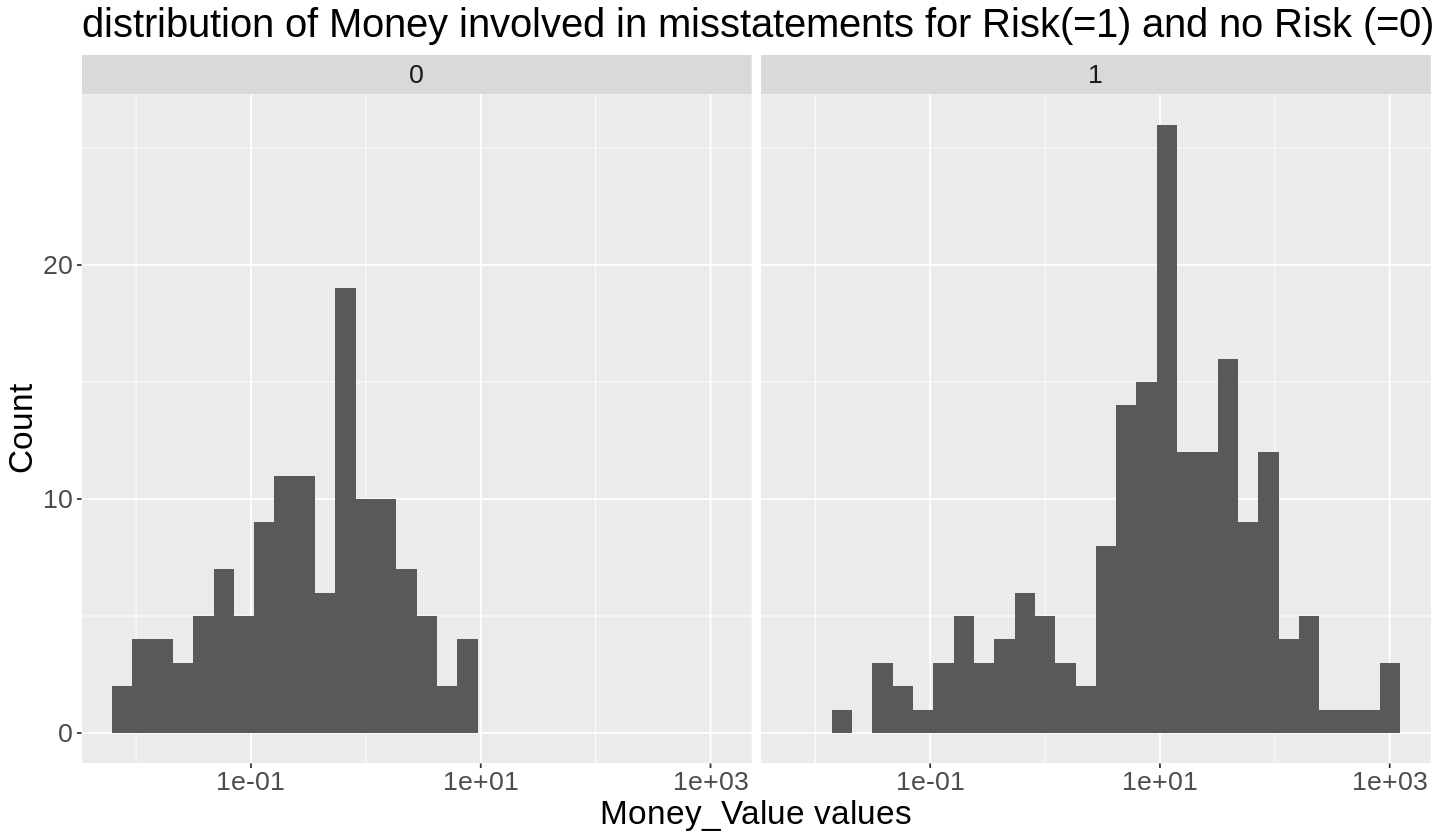

In [28]:
options(repr.plot.width = 12, repr.plot.height = 7)

money_value_plot <- audit_consider %>%
ggplot(aes(x = Money_Value)) +
facet_grid(. ~ Risk) +
geom_histogram() +
labs(x = "Money_Value values", y = "Count") +
ggtitle("distribution of Money involved in misstatements for Risk(=1) and no Risk (=0)") +
theme(text = element_text(size = 20)) +
scale_x_log10()

money_value_plot

#### [Figure 1.132]. Money_Value: Amount of Money involved in misstatements (Hooda 2018)

From Figure 1.132, it's pretty clear that Money_Value values associated with a Risk value of 1 are much higher on average than Money_Value values associated with a Risk value of 0. The histogram for Risk == 1 is shifted farther to the right and has a center of around 10, while the histogram for Risk == 0 has a center of between 0.1 and 1.

#### TOTAL

We haven't done this for TOTAL yet, so let's do that:

Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 64 rows containing non-finite values (stat_bin).”


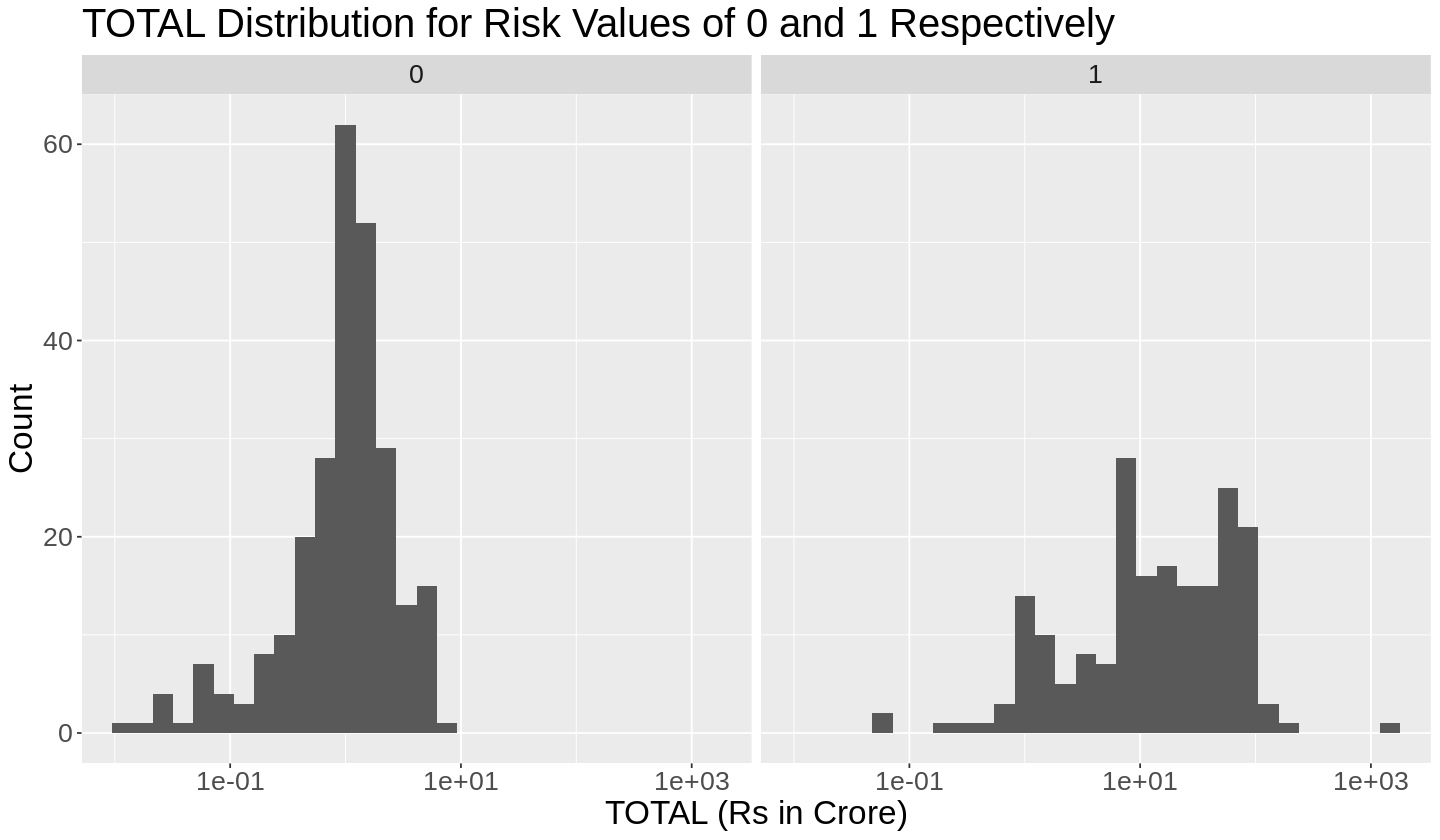

In [11]:
options(repr.plot.width = 12, repr.plot.height = 7)

money_value_plot <- audit_consider %>%
ggplot(aes(x = TOTAL)) +
facet_grid(. ~ Risk) +
geom_histogram() +
labs(x = "TOTAL (Rs in Crore)", y = "Count") +
ggtitle("TOTAL Distribution for Risk Values of 0 and 1 Respectively") +
theme(text = element_text(size = 20)) +
scale_x_log10()

money_value_plot

#### [Figure 1.133]. TOTAL: Discrepencies in planned and unplanned spending

From Figure 1.133, there also appears to be a trend. There are much more TOTAL values greater than 0 if Risk == 1.

Let's create a mean, min, max, and sd table for each of the variables in Table 1.13, separated by Risk value, to further help determine if they would be a good candidate or not. To do this, we will bind 8 rows of data, each with their respective statistic label and statistic values.

In [12]:
bind_rows(filter(audit_consider, Risk == 0) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 0) %>%
bind_rows(audit_consider %>%
         filter(Risk == 0) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 0)),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 0),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 0),
          
          filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 1),
          
filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 1),

filter(audit_consider, Risk == 1) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 1) %>%
bind_rows(audit_consider %>%
         filter(Risk == 1) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 1))) %>%
mutate(Risk = as_factor(Risk), Stat = as_factor(Stat))

PARA_A,PARA_B,TOTAL,Money_Value,History,Stat,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
0.7264217,0.4507789,1.177201,0.3856997,0.003194888,Mean,0
0.9636309,0.8843844,1.328529,1.0864456,0.056523342,SD,0
0.0000000,0.0000000,0.000000,0.0000000,0.000000000,Min,0
5.2000000,7.3700000,7.370000,8.2100000,1.000000000,Max,0
0.0000000,0.0000000,0.000000,0.0000000,0.000000000,Min,1
85.0000000,1264.6300000,1268.910000,935.0300000,9.000000000,Max,1
5.6920127,27.8664706,33.457258,43.3901471,0.284313725,Mean,1
9.7573038,91.6450063,92.690083,123.5624716,0.858196654,SD,1


#### [Table 1.134]. Legend: See [Figure 1.0]

The means of TOTAL for Risk == 1 and Risk == 0 vary greatly. The mean TOTAL for Risk == 0 is about 1, but it is ~33 for Risk == 1. This supports our choice of TOTAL as a predictor variable because it indicates that TOTAL can be used to determine if a firm is fraudulent or not. Same with Money_Value. The mean for Risk == 0 is about 0.5, while the mean for Risk == 1 is about 43. Using the same reasoning, we can conclude that these two variables are good for our model.

That leaves the variable History.

#### History

History could be valuable to our analysis because a fraudulent firm would likely suffer losses on record. The firm could commit fraud to prevent catastrophic loss. In addition, a potentially fraudulent firm would be less likely to have investors and business partners.

Table 1.134 supports adding History as a variable. For Risk == 0, History has a mean of ~0.003 and does not vary by much, only having an SD of ~0.056. In contrast, History for Risk == 1 has a mean of ~0.28 and an SD of ~0.86. History score would be a good predictor to include in our model.

We have considered all the possible predictors and chosen three for the model.

#### Summary of Chosen Variables:

1. History

2. TOTAL

3. Money_Value

4. Risk (predicted)

Before we start the analysis, let's make sure that the number of observations with Risk == 1 and Risk == 0 is somewhat proportional so that we have enough of both to train our model:

In [13]:
audit_risk_data_count <- audit_training %>%
group_by(Risk) %>%
summarize(n = n())

audit_risk_data_count

`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,313
1,204


#### [Figure 1.135]. Risk: If a firm has been determined to be fraudulent (1) or not (0). n: the amount of observations with the respective Risk value.

There is a good ratio, so no upsampling has to be done.

## 1.2 Starting the Analysis

### 1.21 Creating our Specs and Recipes for Cross-Validation

#### Specification

We will use K nearest neighbors classification from tidymodels to create our classification model. Firstly, we have to find an optimum value of K by cross-validation for K = 1 to 50. After determining the new value of K, we will create a new spec that uses the final value of K instead of tune().

In [14]:
set.seed(999998)

audit_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

audit_knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Recipe

Now we will create a recipe for our data. The predicted variable is Risk and the predictors are Money_Value, TOTAL, and History, so we put that as the first argument of recipe().

We should standardize the data because the scales for the variables are very different. History lies about from 0 to 10 while the other variables can range from 0 to ~1200. Hence, let's add step_center() and step_scale().

In [15]:
set.seed(50)

audit_training_recipe <- recipe(Risk ~ Money_Value + History + TOTAL, audit_training) %>%
step_center(all_predictors()) %>%
step_scale(all_predictors())

audit_training_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Centering for all_predictors()
Scaling for all_predictors()

#### vfold_cv cross-validation object

Our final step before we combine these steps into a workflow is to create the vfold_cv object. We will use 5 folds and K values for 1 to 50.

In [16]:
set.seed(1001)

gridvals <- tibble(neighbors = 1:50)
audit_vfold <- vfold_cv(audit_training, C = 5, strata = Risk)

### 1.22 Tuning

Let's start the tuning. First, we will combine the model and the recipe we created. Then we will use tune_grid() to perform the cross-validation for our vfold_cv object that we created earlier and our gridvals tibble from the code block directly above.

In [17]:
set.seed(1015)

audit_training_fit <- workflow() %>%
add_model(audit_knn_spec) %>%
add_recipe(audit_training_recipe) %>%
tune_grid(resamples = audit_vfold, grid = gridvals)

Let's plot our results to determine K. To plot the accuracy vs K, we will use collect_metrics() and then plot accuracy on the y-axis and K values on the x-axis.

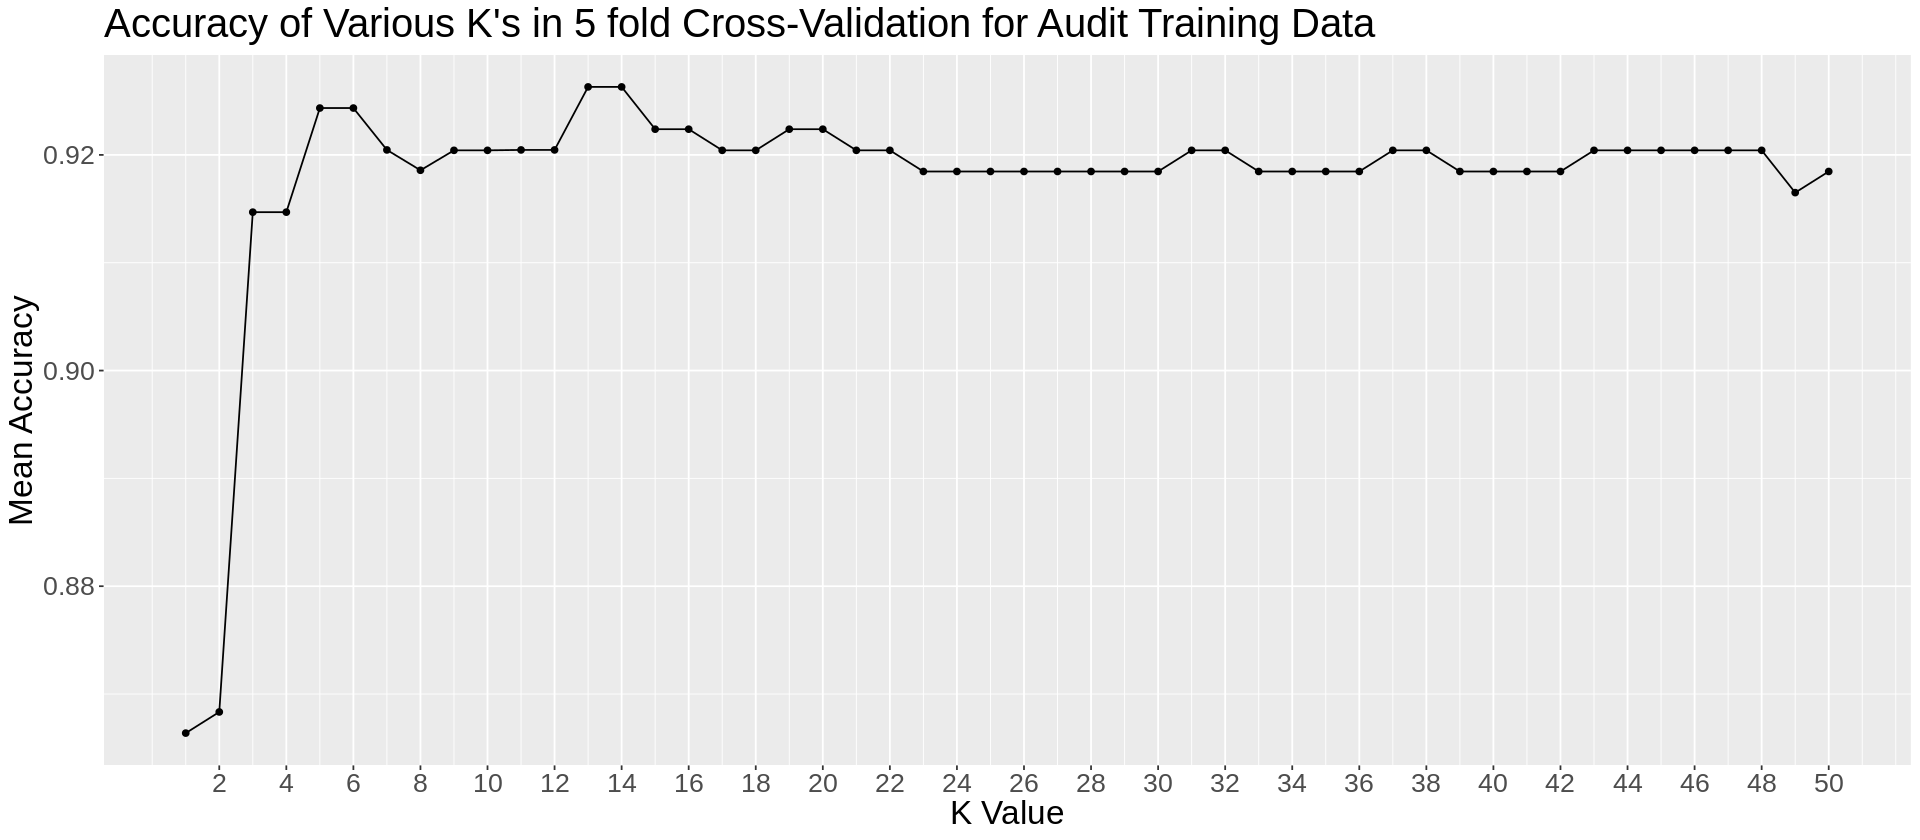

In [18]:
set.seed(26)

options(repr.plot.width = 16)

audit_training_metrics <- collect_metrics(audit_training_fit) %>%
filter(.metric == "accuracy")

audit_training_k_plot <- audit_training_metrics %>%
ggplot(aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "K Value", y = "Mean Accuracy") +
theme(text = element_text(size = 20)) +
ggtitle("Accuracy of Various K's in 5 fold Cross-Validation for Audit Training Data") +
scale_x_continuous(breaks = 2 * c(1:25))

audit_training_k_plot

#### [Figure 1.22]. K Value: The K value for each model. Mean Accuracy: The average accuracy of predicted vs truth in the cross-validation.

Judging from the graph, it appears that we have an optimum K at 13 or 14. Let's pull the optimum K value and its accuracy:

In [19]:
audit_final_k <- audit_training_metrics %>%
arrange(desc(mean)) %>%
select(neighbors) %>%
head(1) %>%
pull()

paste("Final K Value:  K = ", audit_final_k)
audit_final_k_acc <- audit_training_metrics %>%
filter(neighbors == audit_final_k) %>%
select(mean) %>%
pull()

paste("Accuracy: ", audit_final_k_acc * 100, "%")

[1] "Final K Value:  K =  13"

[1] "Accuracy:  92.6305529468681 %"

We arrive at a K value of 13 with an accuracy of around 92.6%, which is fairly high.

Let's create a new spec that uses the final K value.

The spec and recipe are combined, and then the model is fit onto the training data, creating our final fit that we can use to predict Risk.

In [20]:
set.seed(1009)

audit_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = audit_final_k) %>%
set_engine("kknn") %>%
set_mode("classification")

audit_final_fit <- workflow() %>%
add_recipe(audit_training_recipe) %>%
add_model(audit_final_spec) %>%
fit(data = audit_training)

## 1.3 Testing the Model on the Testing Data

### 1.31 Predicting

Our final model has been created with the training data. Let's predict our testing data and produce the table to see roughly how accurate our model is:

In [21]:
set.seed(992)

audit_tested <- bind_cols(audit_testing %>% select(Risk), predict(audit_final_fit, audit_testing))

head(audit_tested, 12)

Risk,.pred_class
<fct>,<fct>
1,1
0,0
0,0
0,0
1,1
1,1
1,1
0,0
1,1


#### [Table 1.31]. Risk: The predicted class, whether or not a firm is considered fraudulent. .pred_class: the predicted class based on the model.

From Table 1.31, it appears that our model has done a pretty good job of predicting whether or not a firm is fraudulent based on the predictor variables. Next, let's visualize our results.

### 1.32 Results

To determine the accuracy of our model, we can use metrics() on audit_tested. After using metrics(), let's filter for only accuracy since that's the only statistic we are interested in seeing.

In [22]:
audit_final_metrics <- metrics(audit_tested, truth = Risk, estimate = .pred_class) %>%
filter(.metric == "accuracy")

audit_final_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9379845


#### [Table 1.32]. .metric: the type of metric measured. .estimator: binary because we had exactly two classes. .estimate: our accuracy.

The final accuracy comes to ~93.8%.

Is this a good accuracy? Let's use the majority classifier to see if wee significantly improved the prediction outcome. Recall the proportions is as follows:

In [23]:
audit_risk_data_count

Risk,n
<fct>,<int>
0,313
1,204


If we always predict majority, the accuracy would be 314/(314+204)= 0.6061, which is significantly lower than the prediction from our model. Therefore our model is indead extracting some useful information from the selected predictor variables.

Let's investigate further by checking the confusion matrix to see the kind of mistakes the model make. We use conf_mat with the same arguments as we did for Table 1.32.

In [24]:
audit_final_mat <- conf_mat(audit_tested, truth = Risk, estimate = .pred_class)

audit_final_mat

          Truth
Prediction   0   1
         0 157  16
         1   0  85

#### [Figure 1.31]. Truth: Risk == 0 or Risk == 1. Prediction: Risk == 0 or Risk == 1. Diagonal: The amount of predictions that had a truth equal to truth and a prediction equal to prediction.

|                  |          |  Actual Values |                |
|:----------------:|----------|:--------------:|:--------------:|
|                  |          |    Positive    |    Negative    |
|**Predicted Value**  | Positive |  True Positive | False Positive|
|                  | Negative | False Negative | True Negative  |

We can see that there were no firm determined to be non-fraudulent by the data but detected as fraudulent by our KNN model. Under the context of our prediction, a false negative would be more harmful than a false positive because agencies would further investigate according to our model and could help manuallly eliminate those cases. In this sense, having 16 false negative and 0 false positive shows that our model has a good accuracy.  

To improve the performance of the model, we can consider adding non-monetary variables like employee count or location count.



## 1.4 Outcomes and Significance

### 1.41 Outcome Summary

We discovered that the model we created was fairly accurate at a percentage accuracy of ~<strong>93.8%</strong>. All 16 of the false predictions in the model were false negatives, meaning that some firms were classified as Risk = 0 but the truth was Risk = 1.

In our proposal, we hypothesized that the accuracy of the model would be "high" for the testing data. Our findings match this hypothesis. All our variables were numeric and related to money. Since detecting fraud cannot be fully determined only from monetary measurements, we expected that the accuracy would not be near 100%. The outcome matches that expectation.

### 1.42 Impacts
The model we developed can significantly reduce the time spent by auditors on gathering, correlating, formatting and summarizing information. Instead, they can start their analysis on the predicted fraudulent by our model and study the implications of these results. This will not only greatly increase their efficiency but also liberate auditors from repetitive work and transform their roles. 

Furthermore, COVID-19 and the resulting environment has changed how we work for the foreseeable future. We can expect more work done digitally, providing more information that can be incorporated into training better models that help with identifing fraudulent cases. The process of which this model is created is reproducable and can be easily edited to add more predictors. Therefore, we can expect the model to have continuing contributions. 

### 1.43 Further Exploration 

* How could we implement non-numeric variables in our classification?
* Can we develop a regression model that produces a level of fraudulent potential instead of a binary result?
* What are some risks to only using measured variables for machine models detecting fraud?

## 1.5 References

Audit Data Set: https://archive.ics.uci.edu/ml/datasets/Audit+Data

Citation Request for Audit Data Set: "This research work is supported by Ministry of Electronics and Information Technology (MEITY), Govt.of India"

Lin C, Chiu A, Huang S, Yen D. 2015. Detecting the financial statement fraud: The analysis of the differences between data mining techniques and experts’ judgments. Science Direct. https://doi.org/10.1016/j.knosys.2015.08.011

Hooda N, Bawa S, Rana P. 2018. Fraudulent firm classification: a case study of an external audit. Taylor & Francis Online. https://doi.org/10.1080/08839514.2018.1451032

> The above article is paywalled. Non pay-walled link: <a href = "https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit">HERE</a>

Hajek P, Henriques R. 2017. Mining corporate annual reports for intelligent detection of financial statement fraud – A comparative study of machine learning methods. Science Direct. https://doi.org/10.1016/j.knosys.2017.05.001

Rezaee Z. 2002. Causes, consequences, and deterence of financial statement fraud. Science Direct.
https://doi.org/10.1016/S1045-2354(03)00072-8